# **Panorama Stitching **

This code will show how to use keypoint detection to detect distinctive points within both images. The matching keypoints are then used to compute a homography which is then used to stitch the images.

Text(0.5, 0, 'Train image (Image to be transformed)')

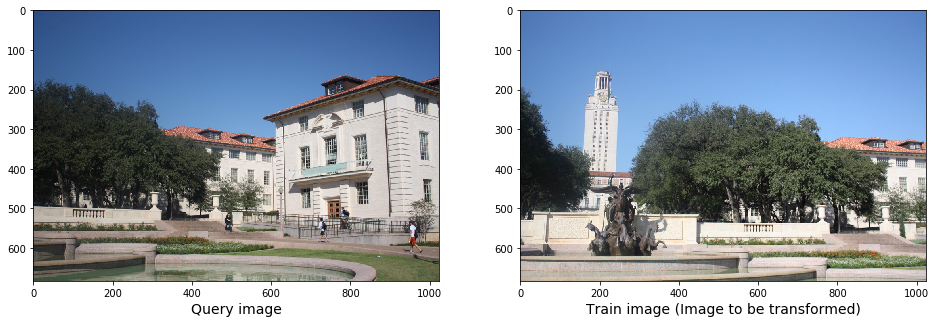

In [29]:
%matplotlib inline

import imageio
import cv2 
import numpy as np
import matplotlib.pyplot as plt

# Load the first image
img1 = imageio.imread('./Data/image01.jpg')
img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)

# Load the second image
img2 = imageio.imread('./Data/image02.jpg')
img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

# Display both images
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(img1, cmap="gray")
ax1.set_xlabel("Query image", fontsize=14)

ax2.imshow(img2, cmap="gray")
ax2.set_xlabel("Train image (Image to be transformed)", fontsize=14)

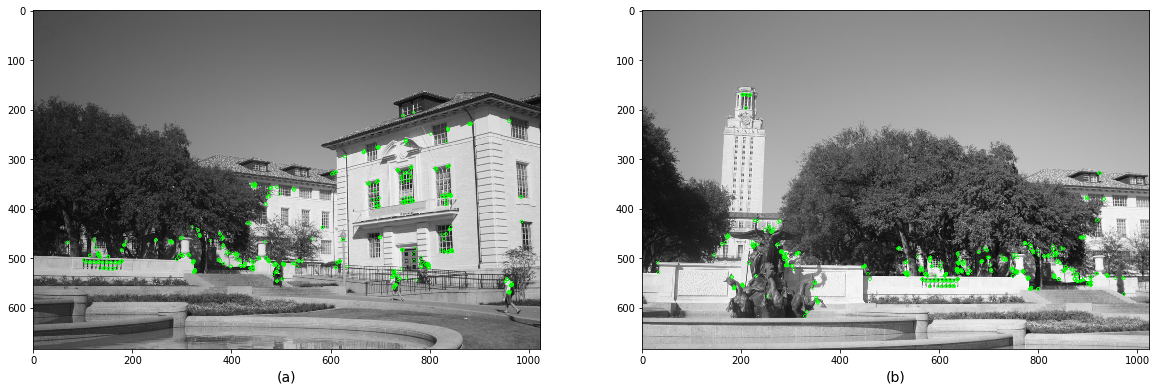

In [30]:
def detectAndDescribe(image):
    """
    Compute key points and feature descriptors using an specific method
    """
    descriptor = cv2.ORB_create()
        
    # get keypoints and descriptors
    kps, features = descriptor.detectAndCompute(image, None)
    
    return kps, features

# Use the ORB function to detect the keypoints and extract the features.
# SIFT was not used here since SIFT is protected by a python and is no 
# longer supported on recent OpenCV. However, one can install earlier
# versions to use SIFT. More information about the ORB function can
# be found in this paper
# E. Rublee, V. Rabaud, K. Konolige and G. Bradski, "ORB: An efficient 
# alternative to SIFT or SURF," 2011 International Conference on Computer 
# Vision, Barcelona, 2011, pp. 2564-2571.
kpsA, featuresA = detectAndDescribe(img1_gray)
kpsB, featuresB = detectAndDescribe(img2_gray)

# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(img1_gray,kpsA,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(img2_gray,kpsB,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

plt.show()

Raw matches (Brute force): 278


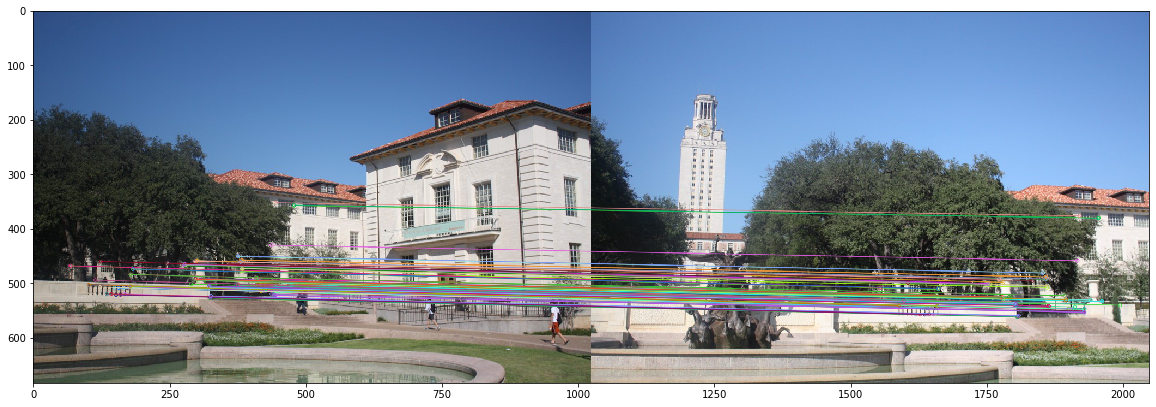

In [31]:
def matchKeyPointsBF(featuresA, featuresB):
    #bf = createMatcher('orb', crossCheck=True)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)    
    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

# Compare all points using brute force
matches = matchKeyPointsBF(featuresA, featuresB)
img3 = cv2.drawMatches(img1,kpsA,img2,kpsB,matches[:100],
                       None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

fig = plt.figure(figsize=(20,8))
plt.imshow(img3)


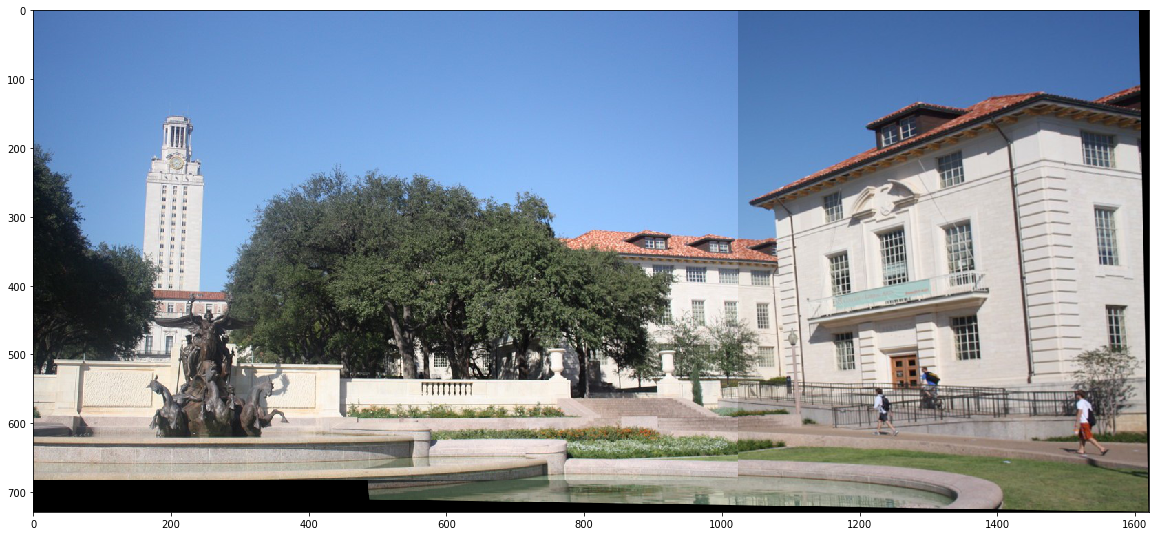

In [38]:
import imutils

def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None
# Compute the homography to align the points
M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=4)
if M is None:
    print("Error!")
(matches, H, status) = M

# Apply panorama correction
width = img1.shape[1] + img2.shape[1]
height = img1.shape[0] + img2.shape[0]

result = cv2.warpPerspective(img1, H, (width, height))
result[0:img2.shape[0], 0:img2.shape[1]] = img2

# transform the panorama image to grayscale and threshold it 
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# Finds contours from the binary image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# get the maximum contour area
c = max(cnts, key=cv2.contourArea)

# get a bbox from the contour area
(x, y, w, h) = cv2.boundingRect(c)

# crop the image to the bbox coordinates
result = result[y:y + h, x:x + w]

# show the cropped image
plt.figure(figsize=(20,10))
plt.imshow(result)
plt.show()